# Import

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Import Data

In [2]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = nn.functional.one_hot(self.y, num_classes=10).to(float)


    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [3]:
# https://www.di.ens.fr/~lelarge/MNIST.tar.gz
train_ds = CTDataset('./MNIST/training.pt')
# test_ds = CTDataset('./MNIST/test.pt')

In [4]:
train, dev, valid = random_split(train_ds, [0.6, 0.2, 0.2])

In [5]:
train_random_sampler = RandomSampler(
    train,
    num_samples=int(min(10_000, len(train)))
)
dev_random_sampler = RandomSampler(
    dev,
    num_samples=int(min(10_000, len(dev)))
)

In [6]:
batch_size = 32
train_dl = DataLoader(
    train,
    batch_size=batch_size,
    # sampler=train_random_sampler
)
dev_dl = DataLoader(
    dev,
    batch_size=batch_size,
    # sampler=dev_random_sampler
)

In [7]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 28
        self.network = nn.Sequential(
            nn.Linear(self.input_size**2,100),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,10)
            # nn.Sigmoid() not required
        )
    def forward(self,x):
        return (
            self.network(
                x.view(-1, self.input_size**2)
            )
            .squeeze()
        )

## Train

In [8]:
def train_model(train_dl, dev_dl, model, loss, optimizer, n_epochs):
    model.train()
    
    train_accuracies = []
    dev_accuracies = []
    epochs = []
    
    for epoch in range(1, n_epochs+1):
        epoch_train_accuracy = 0
        epoch_dev_accuracy = 0
        
        model.train()
        for i, (x, y) in enumerate(train_dl):
            # Update the weights of the network
            optimizer.zero_grad()
            proba = model(x)
            loss_value = loss(proba, y)
            loss_value.backward()
            optimizer.step()
            # Store training data
        
        model.eval()
        for i, (x, y) in enumerate(train_dl):
            proba = model(x)
            true = y.argmax(axis=1)
            pred = proba.argmax(axis=1)
            
            accuracy = torch.sum(pred == true)
            # loss_value = loss(proba, y)
            epoch_train_accuracy += accuracy # loss_value.item() # batch loss
        
        for i, (x, y) in enumerate(dev_dl):
            proba = model(x)
            true = y.argmax(axis=1)
            pred = proba.argmax(axis=1)
            
            accuracy = torch.sum(pred == true)
            # loss_value = loss(proba, y)
            epoch_dev_accuracy += accuracy # loss_value.item() # batch loss
        
        epochs.append(epoch)
        train_accuracies.append(epoch_train_accuracy)
        dev_accuracies.append(epoch_dev_accuracy)

        print(f'Epoch {epoch}/{n_epochs} Completed')

    model.eval()
    return (
        np.array(epochs),
        np.array(train_accuracies)/(len(train_dl)*batch_size) * 100,
        np.array(dev_accuracies)/(len(dev_dl)*batch_size) * 100
    )

In [9]:
model = NeuralNet()

In [10]:
optim_class = torch.optim
optim_children = dir(optim_class)
no_of_optimizers = [o.startswith("_") for o in optim_children].index(True)
optimizers = optim_children[:no_of_optimizers]
optimizers = [o for o in optimizers if o!= "Optimizer"]

for optimizer in optimizers:
  print(getattr(optim_class, optimizer)(model.parameters(), lr=0.01))

ASGD (
Parameter Group 0
    alpha: 0.75
    capturable: False
    differentiable: False
    foreach: None
    lambd: 0.0001
    lr: 0.01
    maximize: False
    t0: 1000000.0
    weight_decay: 0
)
Adadelta (
Parameter Group 0
    differentiable: False
    eps: 1e-06
    foreach: None
    lr: 0.01
    maximize: False
    rho: 0.9
    weight_decay: 0
)
Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)
Adamax (
Pa

In [11]:
# this is our project
optimizer = SGD(model.parameters(), lr=0.01)

In [12]:
loss = nn.CrossEntropyLoss(reduction="sum")
n_epochs = 5

In [13]:
epochs, train_losses, dev_losses = train_model(train_dl, dev_dl, model, loss, optimizer, n_epochs)

Epoch 1/5 Completed
Epoch 2/5 Completed
Epoch 3/5 Completed
Epoch 4/5 Completed
Epoch 5/5 Completed


In [14]:
fig = px.line(
    x = epochs,
    y = [train_losses, dev_losses],
    title = "Loss Curve: Accuracy (Higher is better)",
    range_x = [epochs.min(), epochs.max()],
    range_y = [0, 100], # max(train_losses.max()*1.1, dev_losses.max()*1.1)
    markers=True
)
fig.update_layout(
    xaxis_title="Epoch", yaxis_title="Accuracy"
)
fig.update_traces(patch={
    "marker": {
        "size": 10
    },
    "line": {
        "width": 1,
        # "dash": "dot"
    }
})
series_names = ["Train", "Dev"]
for idx, name in enumerate(series_names):
    fig.data[idx].name = name
    #fig.data[idx].hovertemplate = name

fig.show()

## Test

In [15]:
plot_count = 8
xs, ys = dev[:plot_count+1] # test
yhats = model(xs).argmax(axis=1)
torch.sum(yhats == ys.argmax(axis=1))/plot_count

tensor(1.1250)

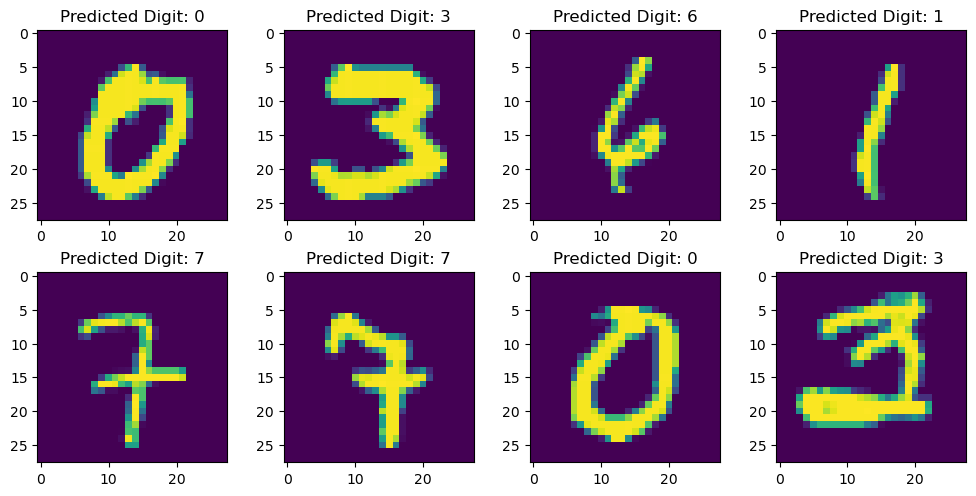

In [16]:
cols = 4
rows = np.ceil(plot_count/cols).astype(int)

fig, ax = plt.subplots(rows, cols,figsize=(10,5))
for i in range(plot_count):
    plt.subplot(rows, cols, i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()